In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix,recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-uci/heart.csv


In [2]:
data = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')
print(data.shape)
data.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## We have 303 rows and 14 columns.
- Our Independent column is 'Target'

1    165
0    138
Name: target, dtype: int64

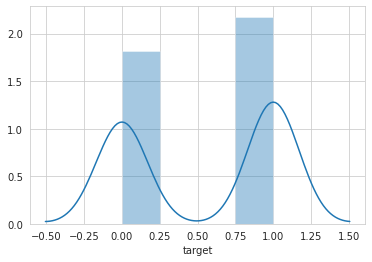

In [4]:
sns.distplot(data['target'],kde= True)
data['target'].value_counts()

## we can see that our independent variable is Balanced.

In [5]:
data.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'serum_cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate',
       'exercise_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

## EDA


In [6]:
data.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'serum_cholesterol', 'fasting_blood_sugar', 'rest_ecg',
       'max_heart_rate', 'exercise_angina', 'st_depression', 'st_slope',
       'num_major_vessels', 'thalassemia', 'target'],
      dtype='object')

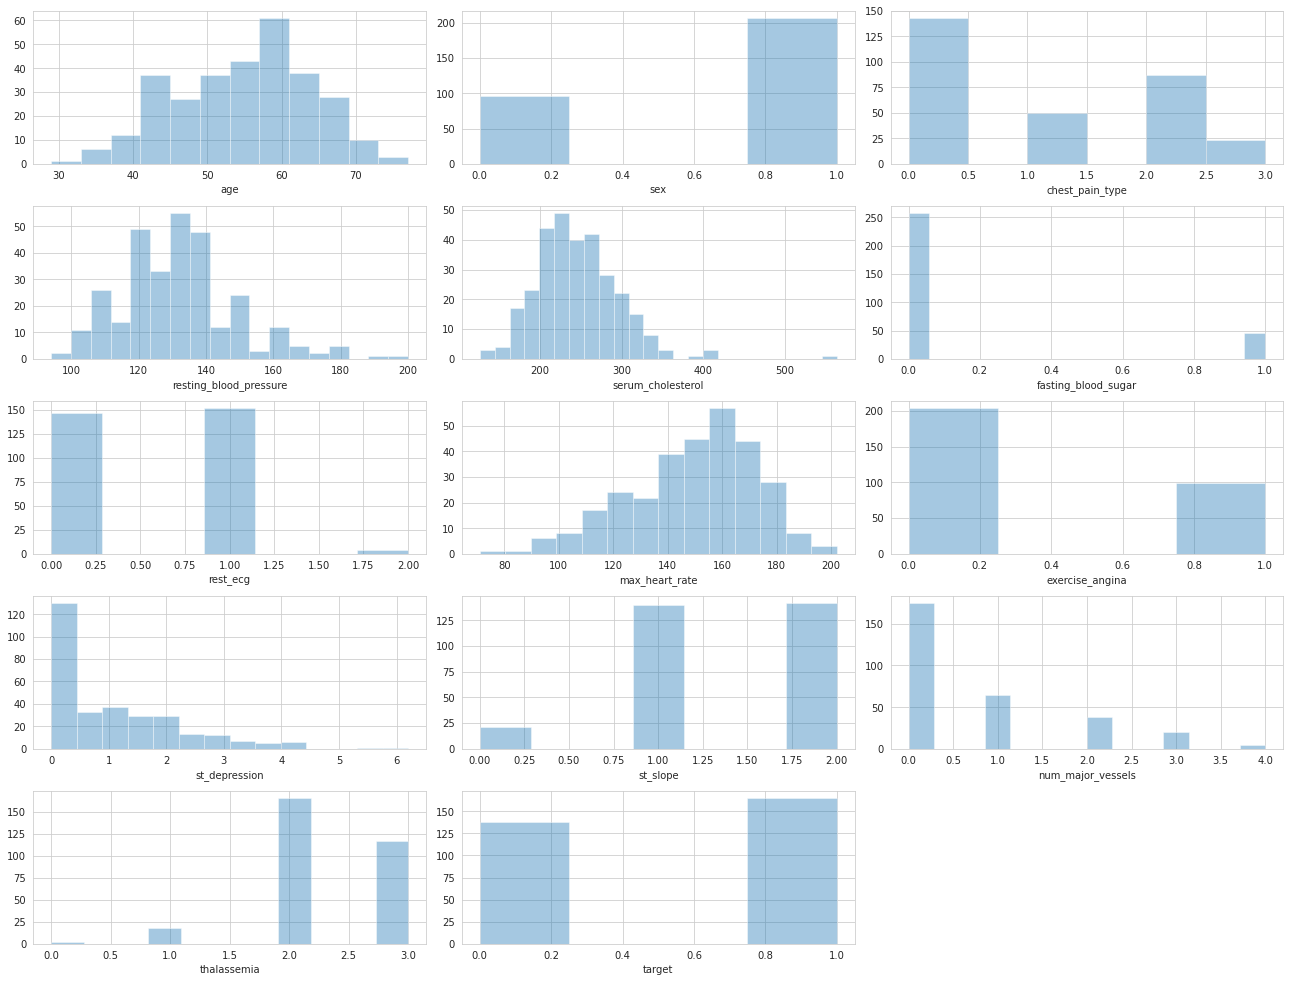

In [7]:
fig=plt.figure(figsize = (18,16))
for index,col in enumerate(data):
    plt.subplot(6,3,index+1)
    sns.distplot(data.loc[:,col],kde =False)
fig.tight_layout(pad=1.0)


## We can clearly see that few columns have categorical data
- sex - Done
- thal -  Done
- ca
- slope - Done
- rest_ecg -Done
- max_heart_rate - Done
- exercise_angina - Done
- fasting_blood_sugar - Done
- serum_cholesterol- Done
- resting_blood_pressure- Done
- chest_pain_type-  Done

In [8]:
data['thalassemia'].value_counts()

2    166
3    117
1     18
0      2
Name: thalassemia, dtype: int64

In [9]:
data['thalassemia'] = data['thalassemia'].replace(0,2)

In [10]:
data['st_slope'].value_counts()


2    142
1    140
0     21
Name: st_slope, dtype: int64

In [11]:
data['rest_ecg'].value_counts()

1    152
0    147
2      4
Name: rest_ecg, dtype: int64

In [12]:
data['rest_ecg'] =data['rest_ecg'].replace(2,0)

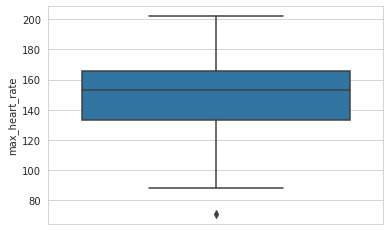

In [13]:
sns.boxplot(y =data['max_heart_rate'])

In [14]:
data =data.drop(data[data['max_heart_rate']<80].index)

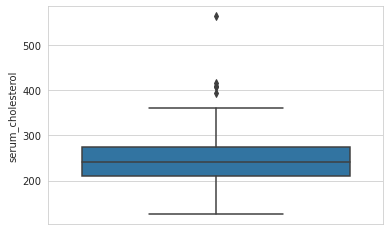

In [15]:
sns.boxplot(y=data['serum_cholesterol'])

In [16]:
data = data.drop(data[data['serum_cholesterol']>500].index)

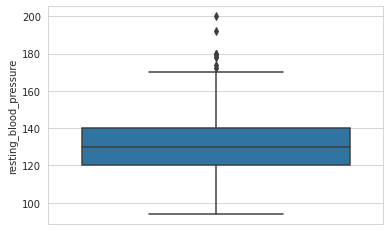

In [17]:
sns.boxplot(y =data['resting_blood_pressure'])

In [18]:
data = data.drop(data[data['resting_blood_pressure']>179].index)

In [19]:
data.shape

(296, 14)

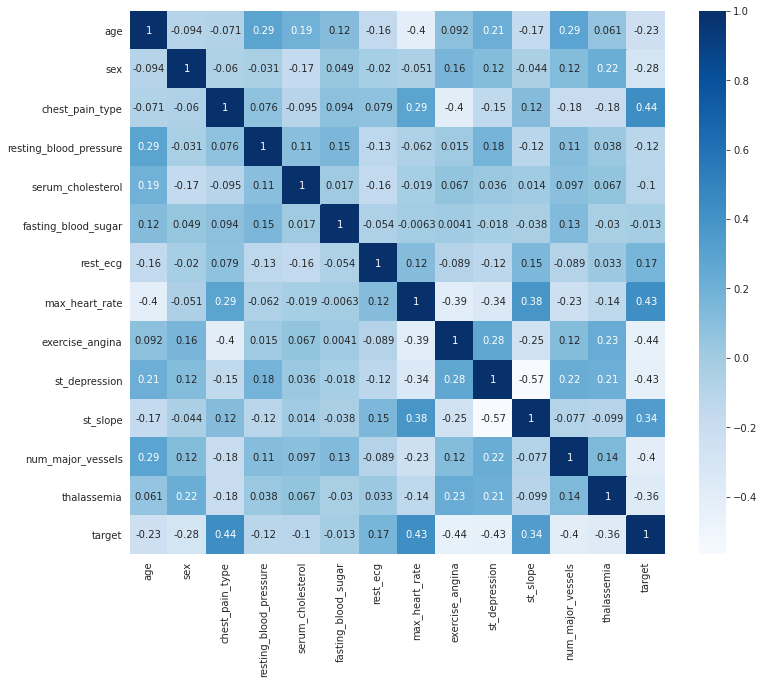

In [20]:
correlation = data.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation,annot=True,cmap = 'Blues')

In [21]:
pd.DataFrame(correlation['target']).sort_values(by = 'target', ascending = False).tail()

,target
sex,-0.283773
thalassemia,-0.364974
num_major_vessels,-0.397584
st_depression,-0.428863
exercise_angina,-0.441020


In [22]:
data = data.drop(['exercise_angina'],axis = 1)

In [23]:
data.shape


(296, 13)

Modeling

In [24]:
X= data.drop(['target'],axis = 1)
y = data['target']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2, random_state = 100)

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict_proba(X_val)[:,1]
score = roc_auc_score(y_val,pred)
score

0.9243604004449388

In [27]:
xgb = XGBClassifier(booster ='gbtree')

param_lst = {
            'eta' : [0.01,0.015,0.025,0.05,0.1,0.15,0.2,0.25],
            'lambda' : [0.01,0.05,0.07,0.1,0.2,0.3,0.4,1.0],
            'alpha' : [0,0.1,0.5,1.0],
            'gamma' : [0.05,0.07,0.1,0.3,0.5,0.7,0.9,1.0],
            'max_depth' : [3,5,7,9,12,15,17,25],
            'min_child_weight' : [1,3,5,7],
            'subsample' : [0.6,0.7,0.8,0.9,1.0],
            'colsample_bytree' : [0.6,0.7,0.8,0.9,1.0],
            'n_estimators': [100,120,130,140,150,160]
}

xgb_tune = RandomizedSearchCV(estimator=xgb, param_distributions= param_lst,
                             n_iter = 20,cv = StratifiedKFold(n_splits=5))

       
xgb_search = xgb_tune.fit(X_train,y_train,
                          early_stopping_rounds = 5,
                           eval_set=[(X_val,y_val)],
                           verbose = False)

best_param = xgb_search.best_params_
xgb = XGBClassifier(**best_param)
print(best_param)

{'subsample': 0.7, 'n_estimators': 160, 'min_child_weight': 5, 'max_depth': 15, 'lambda': 0.07, 'gamma': 0.1, 'eta': 0.1, 'colsample_bytree': 0.9, 'alpha': 0.5}


In [28]:
xgb_search.best_estimator_

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.1, gamma=0.1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0.07, learning_rate=0.100000001, max_delta_step=0,
              max_depth=15, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=160, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0.5,
              reg_lambda=0.0700000003, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
y_pred = xgb_search.predict(X_val)
score0 = accuracy_score(y_pred,y_val)
print('Score: {}%'.format(round(score0*100,4)))

Score: 90.0%


In [30]:
#cross validation for XGBoost
acc_scores1 =  cross_val_score(xgb,X,y,
                                 cv = StratifiedKFold(n_splits=5),
                                 scoring = 'accuracy')
acc_scores1

array([0.83333333, 0.89830508, 0.84745763, 0.84745763, 0.77966102])

In [31]:
acc_scores1.mean()

0.8412429378531072

In [32]:
acc_scores =  cross_val_score(lr,X,y,n_jobs=5,
                                 cv =5,
                                 scoring = 'accuracy')
acc_scores

array([0.81666667, 0.88135593, 0.81355932, 0.84745763, 0.76271186])

In [33]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])